In [6]:
import obspy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
from obspy import read
import scipy.signal
import glob

## Join seismic and infrared signal

In [5]:
ehe_path = "/Users/llayer/analysis/StromboliWF/data/STRA_EHE/"
mic_path = "/Users/llayer/analysis/StromboliWF/data/STRA_MIC/"

In [7]:
ascii_ehe = glob.glob(ehe_path + "*.ascii")
ascii_mic = glob.glob(mic_path + "*.ascii")

In [8]:
def get_tr(file):
    
    st = read(file)
    tr = st[0]
    tr = tr.detrend('demean')
    return {'time': tr.stats.starttime, 'tr': tr}

In [9]:
def param_all(ascii_files):
    
    events = []
    corr_files = 0

    for counter, file in enumerate(ascii_files):
        if counter%100 == 0:
            print( counter )
        try:
            features = get_tr(file)
            if features is not None:
                events.append(features)
            else:
                corr_files += 1
        except:
            print(file)
            corr_files += 1
            
    print( 'Number of bad events' , corr_files)
    print( 'Number of good events' , len(events))

    return pd.DataFrame(events)

In [ ]:
df_ehe = param_all(ascii_ehe)

In [ ]:
df_mic = param_all(ascii_mic)

In [14]:
def corr_t(df):
    df.time = df.time.astype(str)
    df.time = pd.to_datetime(df['time'])

In [15]:
corr_t(df_ehe)
corr_t(df_mic)

In [16]:
df_ehe = df_ehe.rename(columns = {'tr':'tr_ehe'})
df_mic = df_mic.rename(columns = {'tr':'tr_mic'})

In [18]:
df = pd.merge(df_ehe, df_mic, on='time')

In [20]:
df.to_hdf('ehe_mic.h5', 'df')

/usr/local/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['tr_ehe', 'tr_mic'], dtype='object')]

  encoding=encoding,


## Calculate features

In [21]:
df.head()

,time,tr_ehe,tr_mic
0,2019-01-06 10:11:52+00:00,"(2718.356, 1928.356, 1683.356, 1248.356, -361....","(1891.85466667, 6242.85466667, 8317.85466667, ..."
1,2019-08-20 12:28:38+00:00,"(-2426.802, -2145.802, -1174.802, -2130.802, -...","(16758.2546667, 19141.2546667, 18773.2546667, ..."
2,2019-08-06 13:01:05+00:00,"(-827.975333333, -1876.97533333, -1505.9753333...","(6313.448, 7185.448, 10409.448, 15461.448, 152..."
3,2019-07-31 06:56:18+00:00,"(4277.41266667, 6074.41266667, 6934.41266667, ...","(-87782.692, -89412.692, -90584.692, -91695.69..."
4,2018-11-29 18:34:43+00:00,"(-543.451333333, -993.451333333, -1305.4513333...","(-4048.378, -4214.378, -3841.378, -3620.378, -..."


In [113]:
def spect(tr, hist=False, plot=False):
    
    # CALCOLA SPETTRO DI CH1
    tr_spe=tr.copy()
    fs = 50
    f, spe_01 = scipy.signal.welch(tr.data, fs, nperseg=1024)
    tr_spe.data=spe_01
    #print(tr_spe.data)
    
    #tr_spe.plot()
    
    if hist==False:
        tr_spe_fil=tr_spe.filter('bandpass', freqmin=0.01, freqmax=1.5)

        tr_spe_fil_rs=tr_spe_fil.decimate(factor=4, strict_length=False)
        tr_spe_fil_rs.data= (tr_spe_fil_rs.data-min(tr_spe_fil_rs.data))/(max(tr_spe_fil_rs.data)-min(tr_spe_fil_rs.data))

        t1=tr_spe_fil_rs.stats.starttime
        t2=t1+6
        tr_spe_fil_rs_half=tr_spe_fil_rs.slice(t1,t2)
        if plot == True:
            tr_spe_fil_rs_half.plot()
        feat = tr_spe_fil_rs_half.data
    else:
        feat, _ = np.histogram(tr_spe.data, bins=50)
        feat = (feat-min(feat))/(max(feat)-min(feat))
        if plot == True:
            plt.plot(feat)
            plt.show()
    
    return feat

In [107]:
def vlp(tr, plot=False):
    
    # VLP
    temp_tr=tr.copy()
    VLP=temp_tr.filter('bandpass', freqmin=0.05,freqmax=0.5, corners=2, zerophase=True)
    vls_rs=VLP.decimate(factor=16, strict_length=False)
    # Norm
    vls_rs.data = (vls_rs.data-min(vls_rs.data))/(max(vls_rs.data)-min(vls_rs.data)) 
    
    if plot == True:
        vls_rs.plot()
        
    return vls_rs.data

In [127]:
def amp(tr, normed=True, plot=False):
    
    data = tr.data
    start = 0
    sps=50
    end = sps
    
    amplitudes = []
    n_sec = 0
    
    while end <= len(data)-1:
        
        batch = data[start:end]
        amp = max(batch) - min(batch)
        amplitudes.append(amp)
        
        start = end
        end += sps
        n_sec +=1
        
    if normed == True:
        amps_normed = []
        for amp in amplitudes:
            amps_normed.append( (amp * n_sec) / sum(amplitudes) )
        if plot == True:
            plt.plot(amps_normed)
            plt.show()
        return amps_normed
    else:
        if plot == True:
            plt.plot(amplitudes)
            plt.show()
        return amplitudes

In [44]:
df['spect_ehe'] = df.apply(lambda x: spect(x.tr_ehe), axis=1)

In [115]:
df['hist_ehe'] = df.apply(lambda x: spect(x.tr_ehe, hist=True), axis=1)

In [63]:
df['vlp_ehe'] = df.apply(lambda x: vlp(x.tr_ehe), axis=1)

In [64]:
df['amp_ehe'] = df.apply(lambda x: amp(x.tr_ehe), axis=1)

In [130]:
df['amp_mic'] = df.apply(lambda x: amp(x.tr_mic, normed=False), axis=1)

In [138]:
# norm the amplitude globally
min_amp_mic = min(min(df['amp_mic']))
max_amp_mic = max(max(df['amp_mic']))
print(min_amp_mic, max_amp_mic)

def norm(amp_mic):
    return (amp_mic-min_amp_mic)/(max_amp_mic-min_amp_mic)
df['amp_mic_norm'] = df['amp_mic'].apply(norm)

0.0 7371151.0


In [139]:
df.head()

,time,tr_ehe,tr_mic,spect_ehe,vlp_ehe,amp_ehe,hist_ehe,amp_mic,amp_mic_norm
0,2019-01-06 10:11:52+00:00,"(2718.356, 1928.356, 1683.356, 1248.356, -361....","(1891.85466667, 6242.85466667, 8317.85466667, ...","[0.112366807757, 0.112367629911, 0.11245642904...","[0.386262792379, 0.386518958545, 0.39074560545...","[0.326514890575, 0.433249815743, 0.53018392388...","[1.0, 0.0438799076212, 0.0323325635104, 0.0161...","[46734.0, 71519.0, 41877.0, 50673.0, 109472.0,...","[0.00634012245849, 0.00970255527258, 0.0056812..."
1,2019-08-20 12:28:38+00:00,"(-2426.802, -2145.802, -1174.802, -2130.802, -...","(16758.2546667, 19141.2546667, 18773.2546667, ...","[0.133889020493, 0.133890905379, 0.13405857045...","[0.337307408268, 0.337366083979, 0.33875690949...","[1.00766239726, 0.678847243611, 0.642759508183...","[1.0, 0.0488997555012, 0.0660146699267, 0.0391...","[191306.0, 42251.0, 73506.0, 69426.0, 44785.0,...","[0.0259533416152, 0.00573194064265, 0.00997211..."
2,2019-08-06 13:01:05+00:00,"(-827.975333333, -1876.97533333, -1505.9753333...","(6313.448, 7185.448, 10409.448, 15461.448, 152...","[0.101926649729, 0.101927838104, 0.10200274345...","[0.386143058828, 0.386374968311, 0.38910309498...","[0.652903826878, 0.482647366427, 0.47039983469...","[1.0, 0.106870229008, 0.0534351145038, 0.03562...","[20829.0, 29109.0, 17579.0, 58291.0, 45301.0, ...","[0.00282574593846, 0.00394904405024, 0.0023848..."
3,2019-07-31 06:56:18+00:00,"(4277.41266667, 6074.41266667, 6934.41266667, ...","(-87782.692, -89412.692, -90584.692, -91695.69...","[0.117901654723, 0.117904056391, 0.11815798886...","[0.564353180417, 0.56457598397, 0.567651980418...","[0.410664687193, 0.338435644668, 0.49432736636...","[1.0, 0.0621890547264, 0.044776119403, 0.02238...","[25851.0, 79764.0, 95094.0, 46593.0, 74155.0, ...","[0.00350705066278, 0.0108211051436, 0.01290083..."
4,2018-11-29 18:34:43+00:00,"(-543.451333333, -993.451333333, -1305.4513333...","(-4048.378, -4214.378, -3841.378, -3620.378, -...","[0.162770412981, 0.162780058614, 0.16351214765...","[0.432522246811, 0.432303967091, 0.42926316622...","[0.386777232948, 0.344802996445, 0.44083185946...","[1.0, 0.0948509485095, 0.059620596206, 0.04065...","[6148.0, 9884.0, 20394.0, 15062.0, 14226.0, 24...","[0.000834062414404, 0.00134090320494, 0.002766..."


## Plot a few signals

In [128]:
def plot(df, iSig):
    
    signal = df.iloc[iSig]
    
    # EHE full signal
    print( 'EHE full signal' )
    signal['tr_ehe'].plot()
    
    # MIC full signal
    print( 'MIC full signal' )
    signal['tr_mic'].plot()   
    
    # EHE vlp signal
    print( 'EHE vlp' )
    vlp(signal['tr_ehe'], plot=True)
    
    # Spectrum ehe
    print( 'EHE spectrum filtered' )
    spect(signal['tr_ehe'], hist=False, plot=True)
    
    # Spectrum ehe
    print( 'EHE spectrum histo' )
    spect(signal['tr_ehe'], hist=True, plot=True)
    
    # EHE amplitude 
    print( 'EHE amplitude' )
    amp(signal['tr_ehe'], normed=True, plot=True)
    
    # EHE vlp signal
    print( 'MIC amp' )
    amp(signal['tr_mic'], normed=False, plot=True) 

EHE full signal


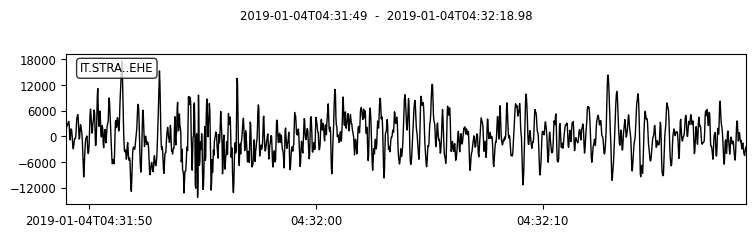

MIC full signal


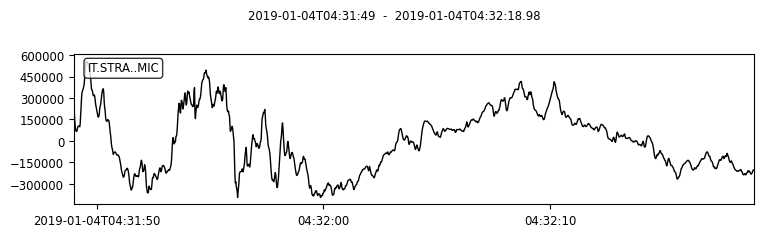

EHE vlp


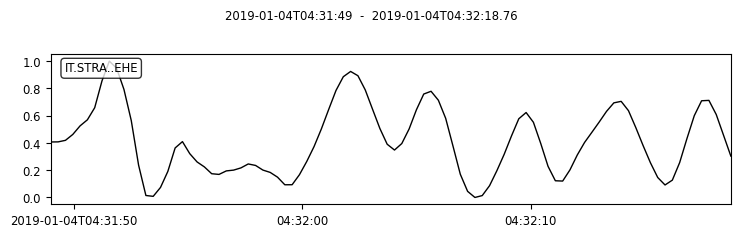

EHE spectrum filtered


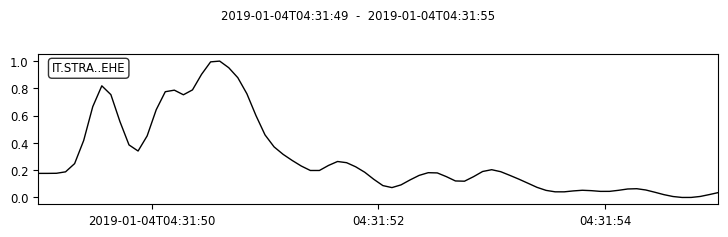

EHE spectrum histo


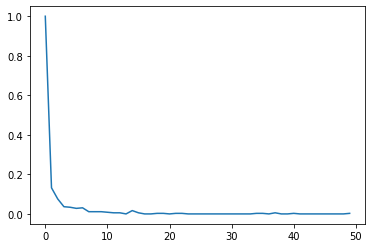

EHE amplitude


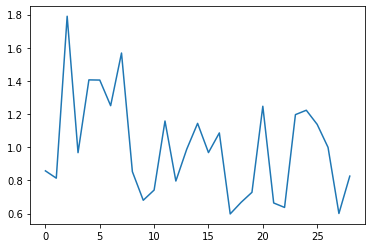

MIC amp


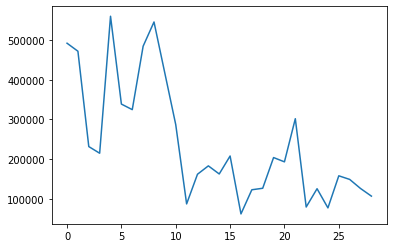

In [129]:
plot(df, 52)

In [87]:
def comp(col, sort=False, nvals=100):

    c = np.array(list(df[col].values))
    for i in range(nvals):
        if sort==True:
            plt.plot(np.sort(c[i]))
        else:
            plt.plot(c[i])

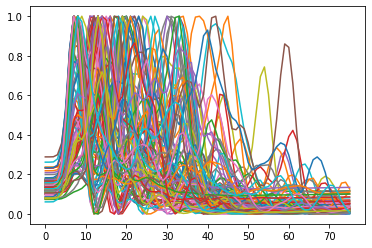

In [89]:
comp('spect_ehe', sort=False)

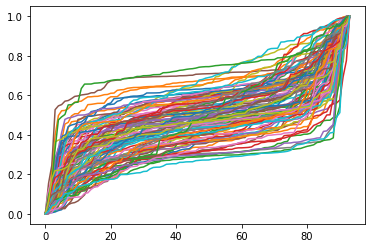

In [90]:
comp('vlp_ehe', sort = True)

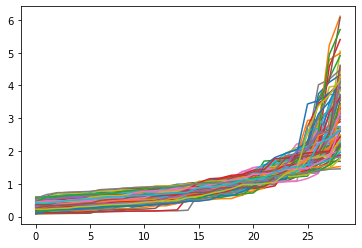

In [91]:
comp('amp_ehe', sort=True)

In [98]:
df.to_hdf('features_ehe_mic.h5', 'df')

/usr/local/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['tr_ehe', 'tr_mic', 'spect_ehe', 'vlp_ehe', 'amp_ehe'], dtype='object')]

  encoding=encoding,
